# ***Dataset Correlations***

This notebook shows the correlations exploration of the sections & replicas.

### ***Import packages***

Next we import all the necessary packages for this notebook:

In [1]:
import os
import re
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.patches import Rectangle
from matplotlib import pyplot as plt
from scipy import stats
from skimage import filters
from skimage.morphology import disk
from tqdm.notebook import tqdm
from pyimzml.ImzMLParser import ImzMLParser
from typing import Tuple, List, Dict
from pathlib import Path

# Define default font size
plt.rcParams.update({'font.size': 12})

### ***Constants definitions***

Next, let's define some constant variables for this notebook:

In [2]:
# Define folder that contains the dhg dataset
DHG_PATH = "./../DHG/"
# Define folder that contains the preprocessed dataset
PREPROCESSED_PATH = f"{DHG_PATH}/preprocessed"
# Define file that contains dhg metadata
METADATA_PATH = f"{DHG_PATH}/metadata.csv"
# Define path to save plots
PLOTS_PATH = "./../plots_and_their_data/correlations"
# Define the type of wanted correlation
CORR_TYPE = "pearson"
# Define mass resolution of the data
MASS_RESOLUTION = 0.025
# Define representative peaks 
REPRESENTATIVE_PEAKS = [794.5, 834.5, 886.6]

### ***Creating output folder***

Next, let's create the output folder:

In [3]:
# Create output folder if doesn't exist
Path(PLOTS_PATH).mkdir(parents=True, exist_ok=True)

### ***Reading MSI metadata***

Next, lets read the metadata file:

In [4]:
# read metadata csv
metadata_df = pd.read_csv(METADATA_PATH)

### ***Define function to read a MSI***

Next, let's define a function to read a MSI:

In [5]:
def read_msi(p: ImzMLParser) -> Tuple[np.ndarray, np.ndarray]:
  """
    Function to read a continuos imzML parser object into a numpy array.

    Args:
        p (ImzMLParser): The imzML parser.
    Returns:
        Tuple[np.ndarray, np.ndarray]: Numpy 3D matrix where y coordinate
            (axis=0), x coordinate (axis=1), intensities values (axis=2)
            and continuos mzs values.

    """
  # Get shape of mzs values
  max_z = p.mzLengths[0]
  # Get shape of y axis
  max_y = p.imzmldict["max count of pixels y"]
  # Get shape of x axis
  max_x = p.imzmldict["max count of pixels x"]
  # Create empty numpy 3D matrix
  msi = np.zeros((max_y, max_x, max_z))
  # Loop over each coordinate and add to 3D matrix
  for i, (x, y, _) in tqdm(
      enumerate(p.coordinates), total=len(p.coordinates), desc="Spectra Loop"
  ):
    # Get mzs and intenisties
    mzs, ints = p.getspectrum(i)
    # Add intensities to x,y coordinate
    msi[y - 1, x - 1, :] = ints
  return mzs, msi

### ***Define function to get correlations***

Next, let's define a function to read a MSI:

In [6]:
def corr(
    i_keys: List[str], j_keys: List[str], i_vals: Dict[str, np.ndarray],
    j_vals: Dict[str, np.ndarray], corr_type: str = "pearson"
) -> pd.DataFrame:
  """Function to calculate correlation matrix

  Args:
      i_keys (List[str]):  Matrix i (rows) keys.
      j_keys (List[str]): Matrix i (columns) keys.
      i_vals (Dict[str, np.ndarray]): Dict with keys corresponding to i_keys
        and values of the keys.
      j_vals (Dict[str, np.ndarray]): Dict with keys corresponding to j_keys
        and values of the keys.
      corr_type (str, optional): Correlation type . Defaults to "pearson".
      

  Returns:
      pd.DataFrame: Correlation matrix where index is i_keys and columns are
        j_keys and each cell [i_key, j_key] is the correlation between i_val
        and j_val.

  """
  # Create empty correlation matrix
  corr_m = np.zeros((len(i_keys), len(j_keys)))
  # Loop over i keys
  for idx_i, key_i in enumerate(i_keys):
    # Loop over j keys
    for idx_j, key_j in enumerate(j_keys):
      # Calculate corelation between i_val and j_val
      if corr_type == "kendall":
        corr_m[idx_i, idx_j] = stats.kendalltau(i_vals[key_i], j_vals[key_j])[0]
      elif corr_type == "spearman":
        corr_m[idx_i, idx_j] = stats.spearmanr(i_vals[key_i], j_vals[key_j])[0]
      else:
        corr_m[idx_i, idx_j] = stats.pearsonr(i_vals[key_i], j_vals[key_j])[0]
  # return correlation data frame
  return pd.DataFrame(corr_m, index=i_keys, columns=j_keys)

### ***Get samples mean spectra***

Next, let's get tissue and non-tissue mean and standard deviation spectra for each sample (before and after ZScore):

In [7]:
def get_top_k_peaks(spectra:np.ndarray, mzs:np.ndarray, k:int):
  indexes = np.argsort(spectra)
  top_k = np.array([], dtype=np.float32)
  for index in indexes[::-1]:
    mz = mzs[index]
    has_mz = ((top_k >= mz - MASS_RESOLUTION) & (top_k <= mz + MASS_RESOLUTION)).any()
    if has_mz == False:
      top_k = np.append(top_k, [mz])
    if top_k.shape[0] >= k:
      return top_k
  return top_k

In [8]:
# Create dict's to store each sample spectra's mean
# for tissue and non-tissue spectra's
sample_tissue_mean = {}
sample_non_tissue_mean = {}

# Create dict's to store each sample spectra's mean after z-score
# normalization by sample non-tissue spectra's mean and standard deviation
# for tissue and non-tissue spectra's
z_score_sample_tissue_mean = {}
z_score_sample_non_tissue_mean = {}

# Define object to store common mz values
mzs = None

# Loop over each sample
for _, row in tqdm(
    metadata_df.iterrows(), total=metadata_df.shape[0], desc="MSI Loop"
):
  # Parse the msi file
  with ImzMLParser(
      os.path.join(PREPROCESSED_PATH, f"{row.sample_file_name}.imzML")
  ) as reader:
    # Get full msi
    mzs, data = read_msi(reader)
    # Define filter of representative peaks
    filter_all = False
    for peak in REPRESENTATIVE_PEAKS:
      filter_all |= (mzs >=
                     peak - MASS_RESOLUTION) & (mzs <= peak + MASS_RESOLUTION)
    # Get representative peaks accumulative image
    representative_peaks_img = data[:, :, filter_all].sum(axis=-1)
    # Remove salt and pepper noise
    smooth = filters.median(representative_peaks_img, disk(2))
    # Threshold image
    thresh_img = (smooth > filters.threshold_mean(smooth))
    # Get tissue spectra's mean
    sample_tissue_mean[row.sample_file_name] = data[thresh_img, :].mean(axis=0)
    # Get non-tissue spectra's mean
    sample_non_tissue_mean[row.sample_file_name
                          ] = data[~thresh_img, :].mean(axis=0)
    # Get non-tissue spectra's std
    sample_non_tissue_std = data[~thresh_img, :].std(axis=0)
    # Get tissue spectra's mean after z-score normalization by sample
    # non-tissue spectra's mean and standard deviation
    z_score_sample_tissue_mean[row.sample_file_name] = (
        (data[thresh_img, :] - sample_non_tissue_mean[row.sample_file_name]) /
        sample_non_tissue_std
    ).mean(axis=0)
    # Get non-tissue spectra's mean after z-score normalization by sample
    # non-tissue spectra's mean and standard deviation
    z_score_sample_non_tissue_mean[row.sample_file_name] = (
        (data[~thresh_img, :] - sample_non_tissue_mean[row.sample_file_name]) /
        sample_non_tissue_std
    ).mean(axis=0)

MSI Loop:   0%|          | 0/48 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/4218 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/4845 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/5073 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/4386 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/3139 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/6162 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/8112 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/4482 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/3510 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/5852 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/7144 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/4480 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/5810 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/7735 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/7553 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/8918 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/3180 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/2968 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/4899 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/5589 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/5382 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/6348 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/5934 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/6030 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/4422 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/4154 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/4355 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/5025 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/3500 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/2660 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/4550 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/3015 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/2295 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/5986 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/5256 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/2993 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/4015 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/4307 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/4015 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/5328 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/5904 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/5760 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/5832 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/6048 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/7990 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/7140 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/3100 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/2950 [00:00<?, ?it/s]

### ***Define correlation plots***

Next, let's get define correlation plots we want to create:

In [9]:
# Get section sample file names
section_sample_file_names = metadata_df[metadata_df.sample_type == "section"
                                       ].sample_file_name
section_sample_file_names = section_sample_file_names.reset_index(drop=True)

# Get replica sample file names
replica_sample_file_names = metadata_df[metadata_df.sample_type == "replica"
                                       ].sample_file_name
replica_sample_file_names = replica_sample_file_names.reset_index(drop=True)

# Create mapper to plot params
plot_params_map = {
    "section": section_sample_file_names,
    "replica": replica_sample_file_names,
    "tissue": sample_tissue_mean,
    "non-tissue": sample_non_tissue_mean,
    "z-score-tissue": z_score_sample_tissue_mean,
    "z-score-non-tissue": z_score_sample_non_tissue_mean
}

# Create correlation plot combinations
combinations = [
    ("section", "section", "tissue", "tissue"),
    ("section", "section", "non-tissue", "non-tissue"),
    ("section", "section", "tissue", "non-tissue"),
    ("replica", "replica", "tissue", "tissue"),
    ("replica", "replica", "non-tissue", "non-tissue"),
    ("replica", "replica", "tissue", "non-tissue"),
    ("section", "replica", "tissue", "tissue"),
    ("section", "replica", "non-tissue", "non-tissue"),
    ("section", "replica", "tissue", "non-tissue"),
    ("section", "section", "z-score-tissue", "z-score-tissue"),
    ("section", "section", "z-score-non-tissue", "z-score-non-tissue"),
    ("section", "section", "z-score-tissue", "z-score-non-tissue"),
    ("replica", "replica", "z-score-tissue", "z-score-tissue"),
    ("replica", "replica", "z-score-non-tissue", "z-score-non-tissue"),
    ("replica", "replica", "z-score-tissue", "z-score-non-tissue"),
    ("section", "replica", "z-score-tissue", "z-score-tissue"),
    ("section", "replica", "z-score-non-tissue", "z-score-non-tissue"),
    ("section", "replica", "z-score-tissue", "z-score-non-tissue")
]

### ***Plot correlation plots***

Next, let's get plot correlation plots:

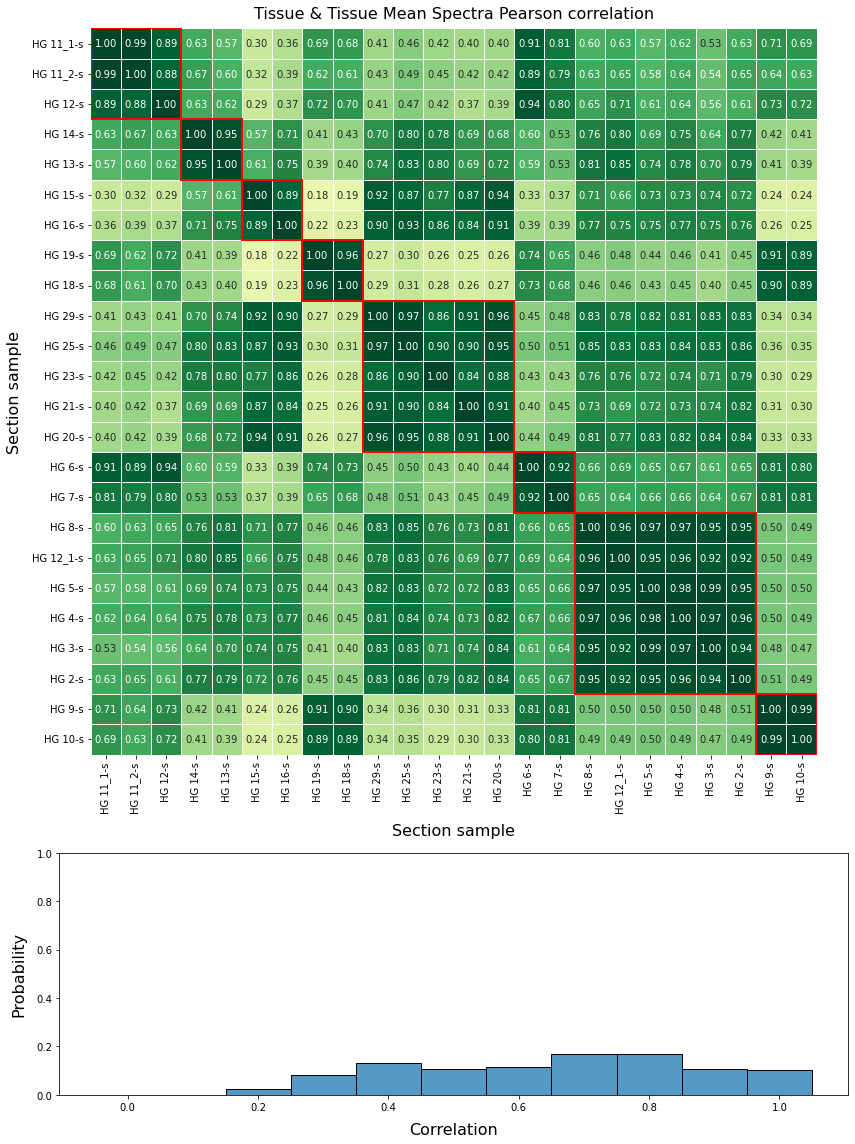

<Figure size 432x288 with 0 Axes>

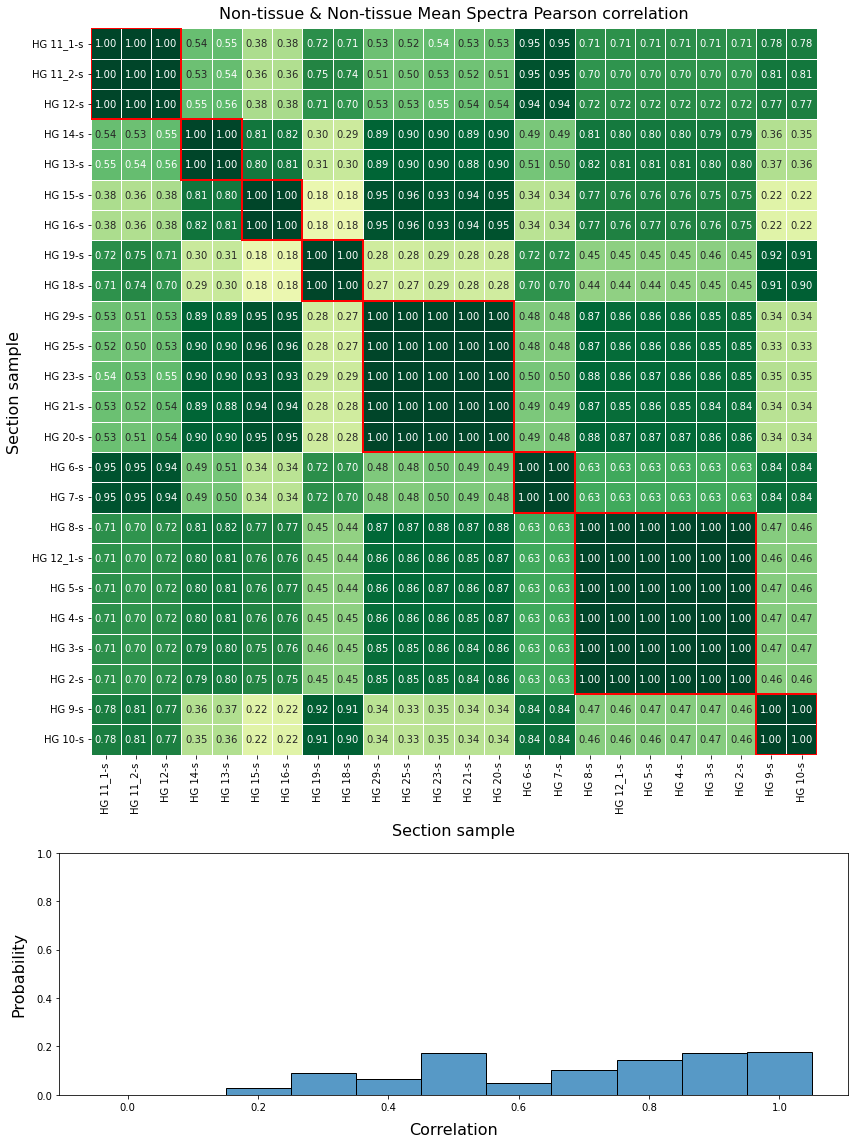

<Figure size 432x288 with 0 Axes>

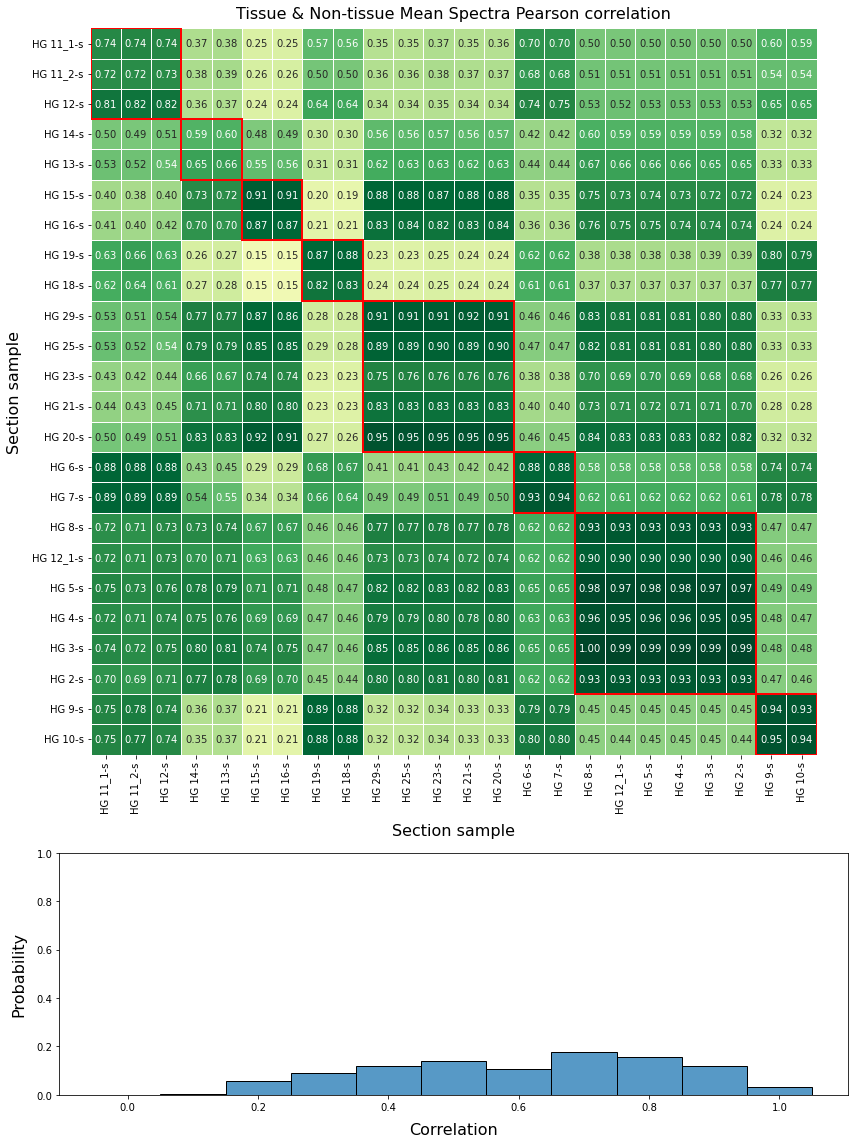

<Figure size 432x288 with 0 Axes>

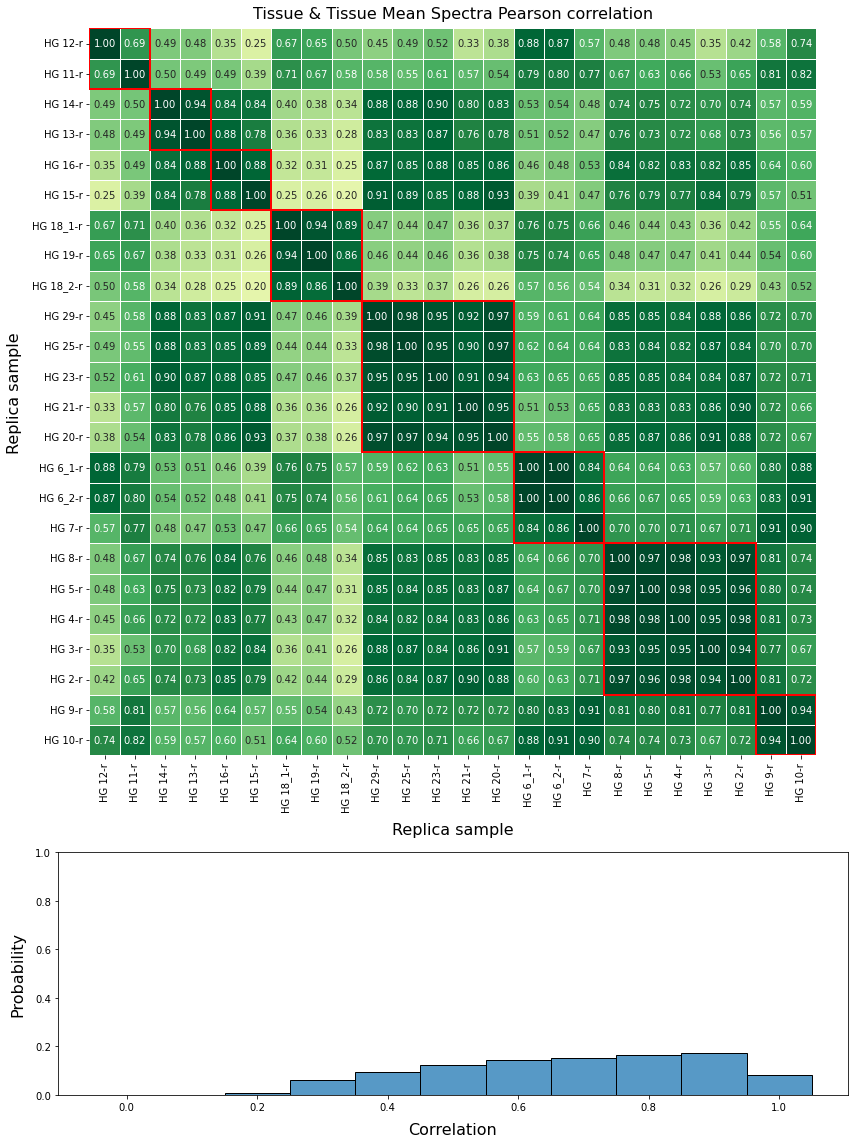

<Figure size 432x288 with 0 Axes>

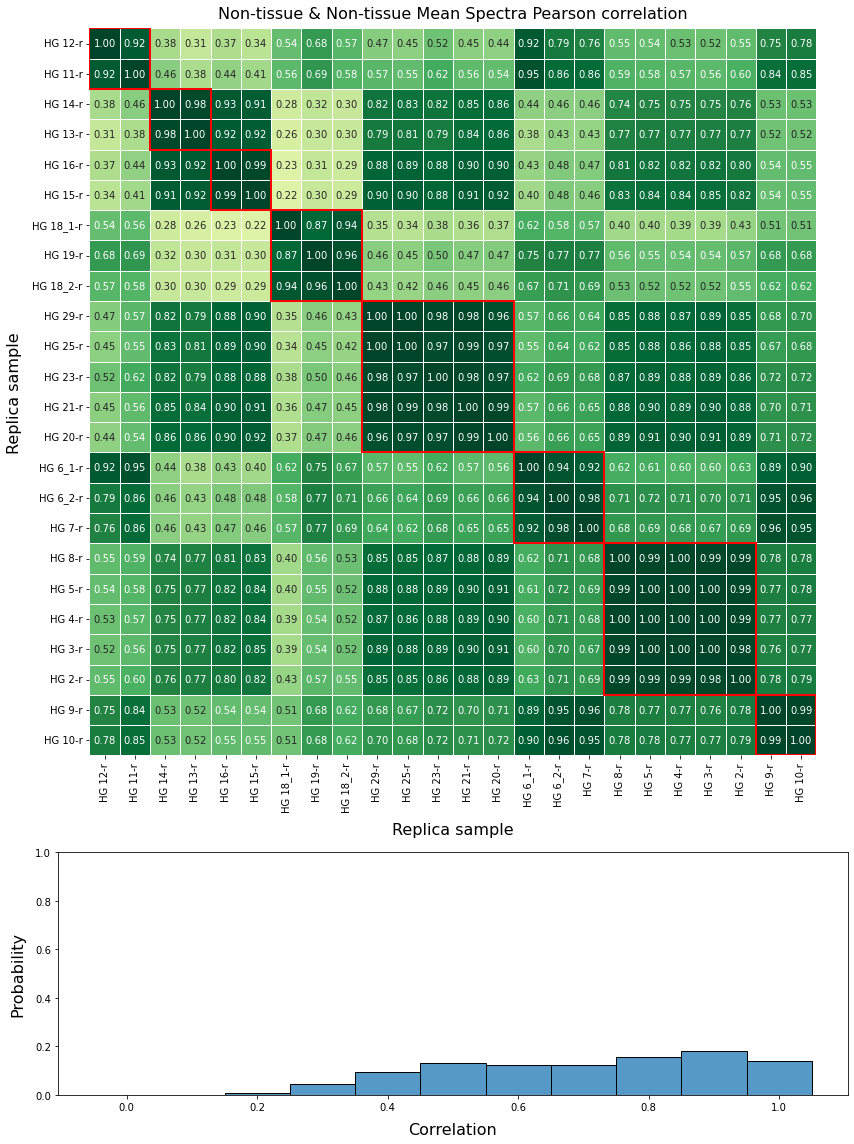

<Figure size 432x288 with 0 Axes>

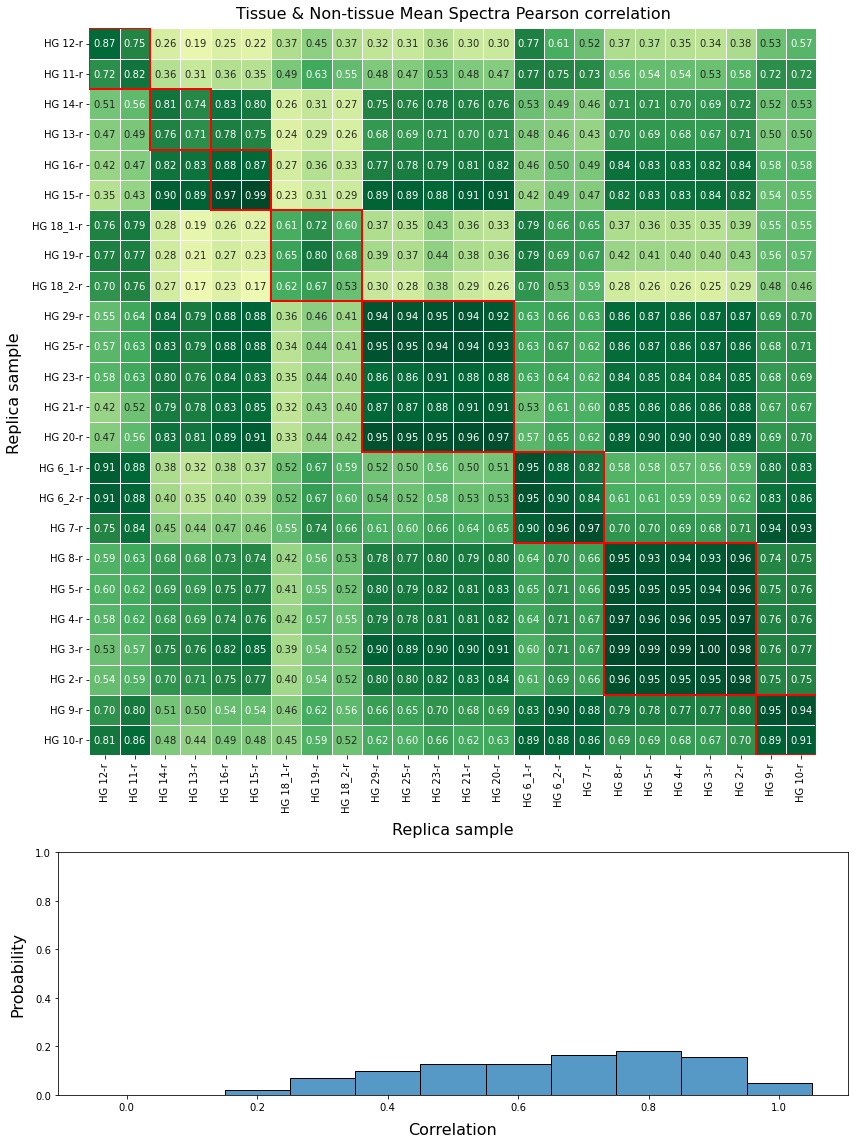

c:\Users\Leor\anaconda3\envs\tf_gpu_jup\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Figure size 432x288 with 0 Axes>

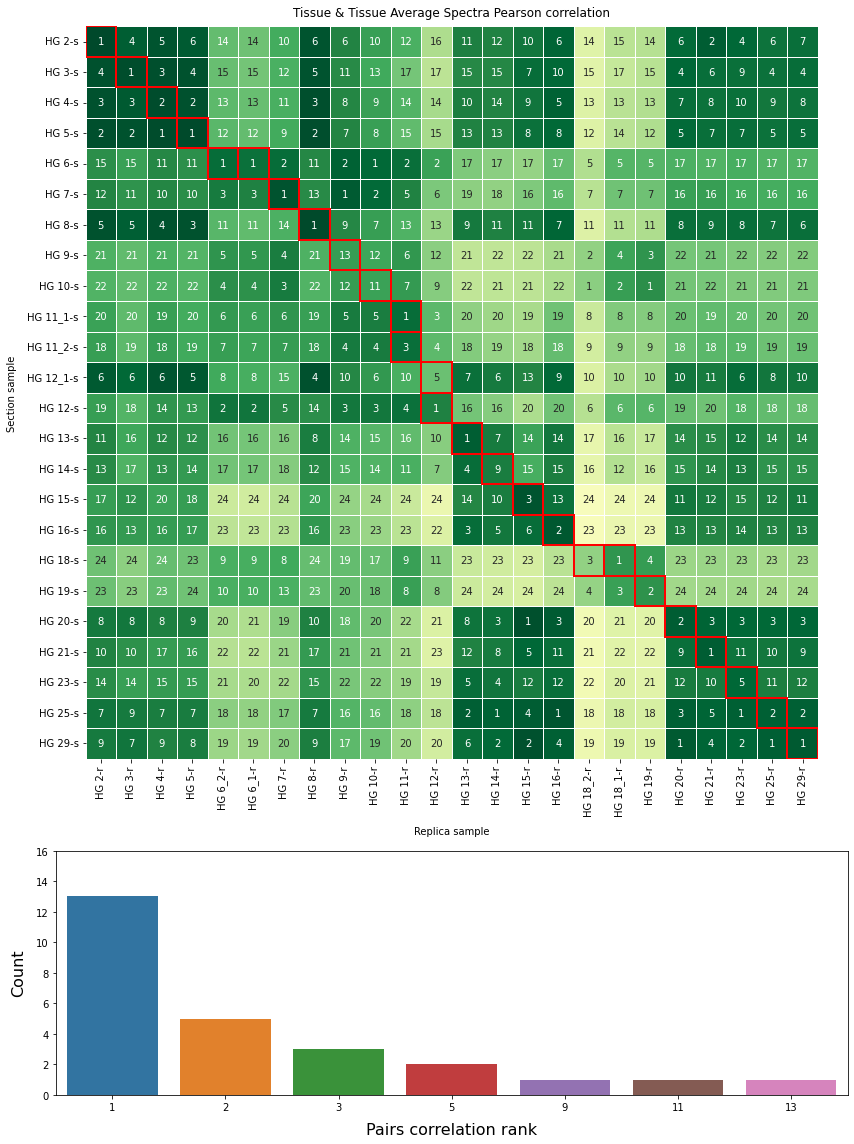

c:\Users\Leor\anaconda3\envs\tf_gpu_jup\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Figure size 432x288 with 0 Axes>

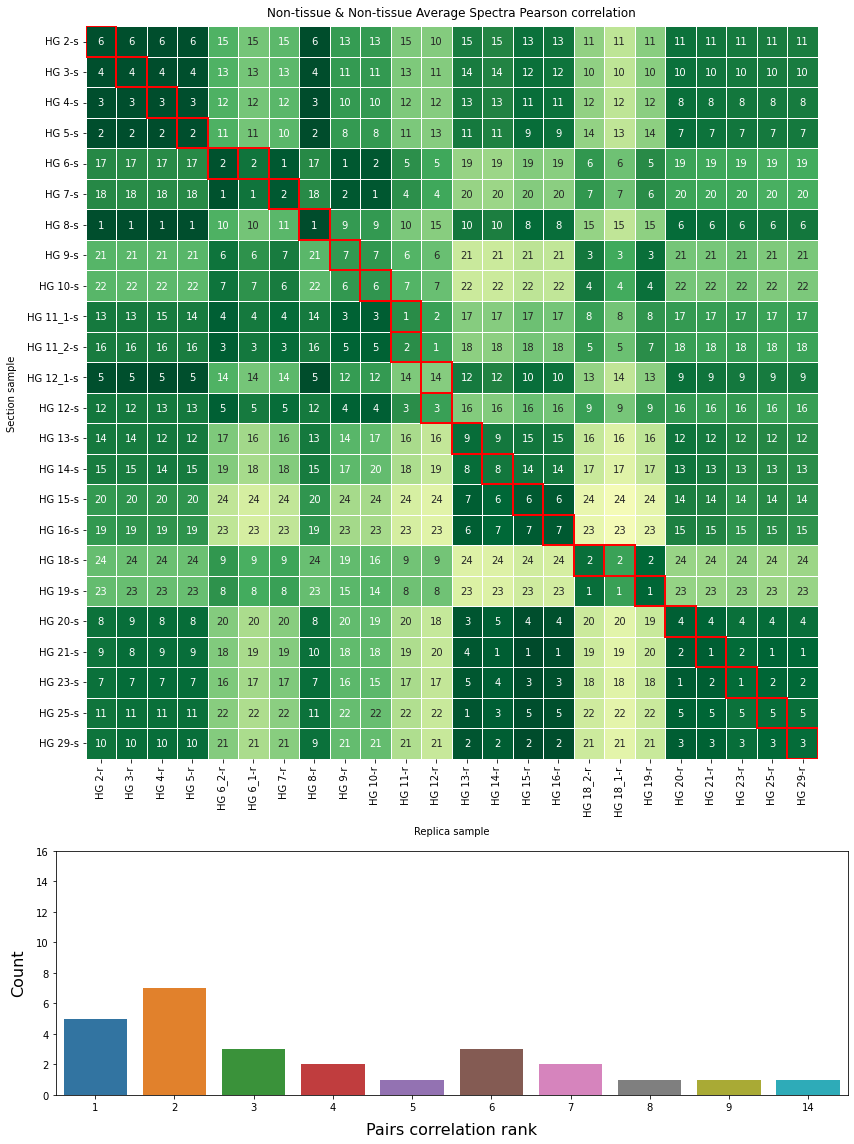

c:\Users\Leor\anaconda3\envs\tf_gpu_jup\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Figure size 432x288 with 0 Axes>

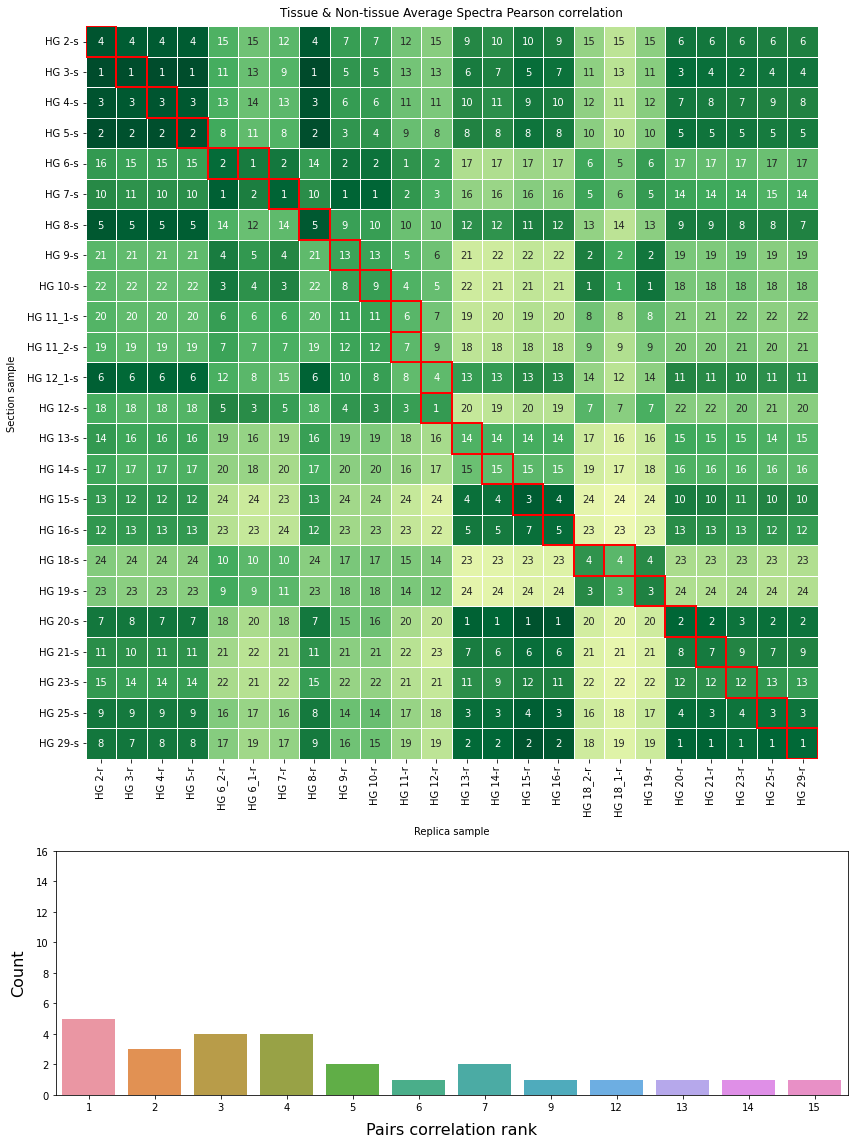

<Figure size 432x288 with 0 Axes>

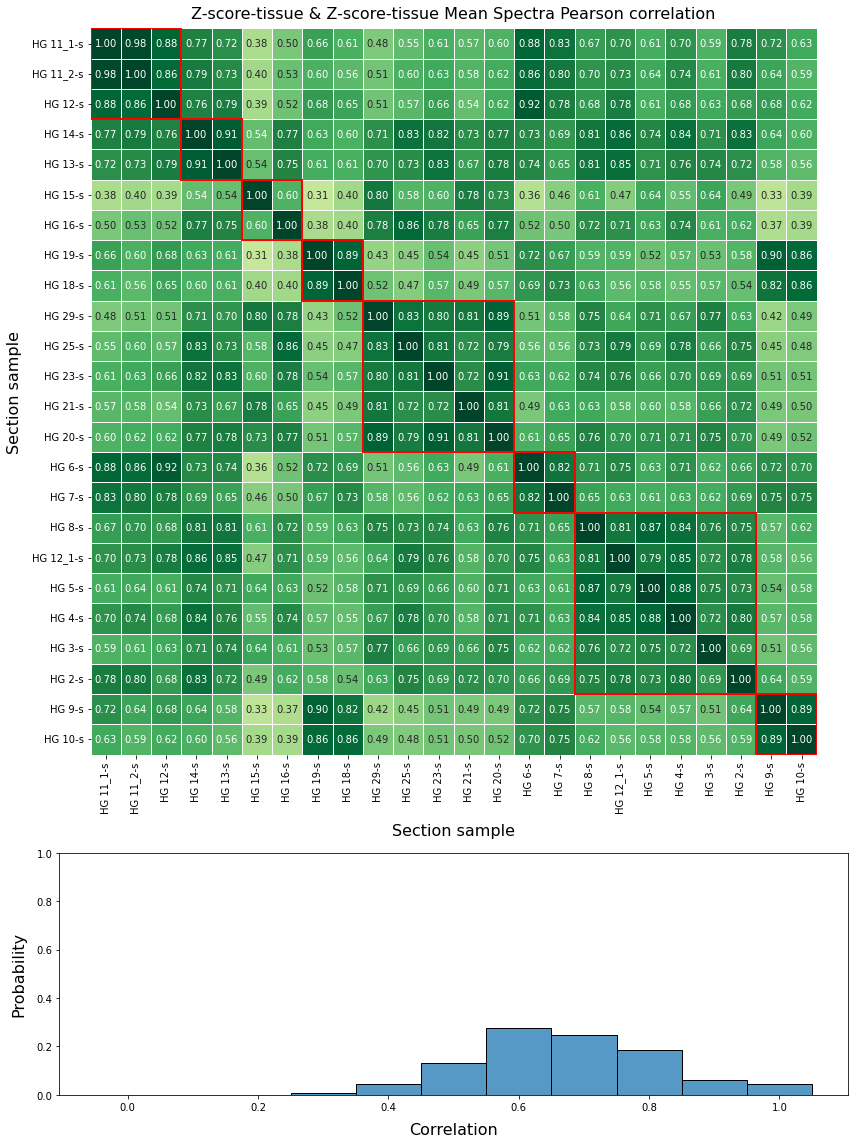

<Figure size 432x288 with 0 Axes>

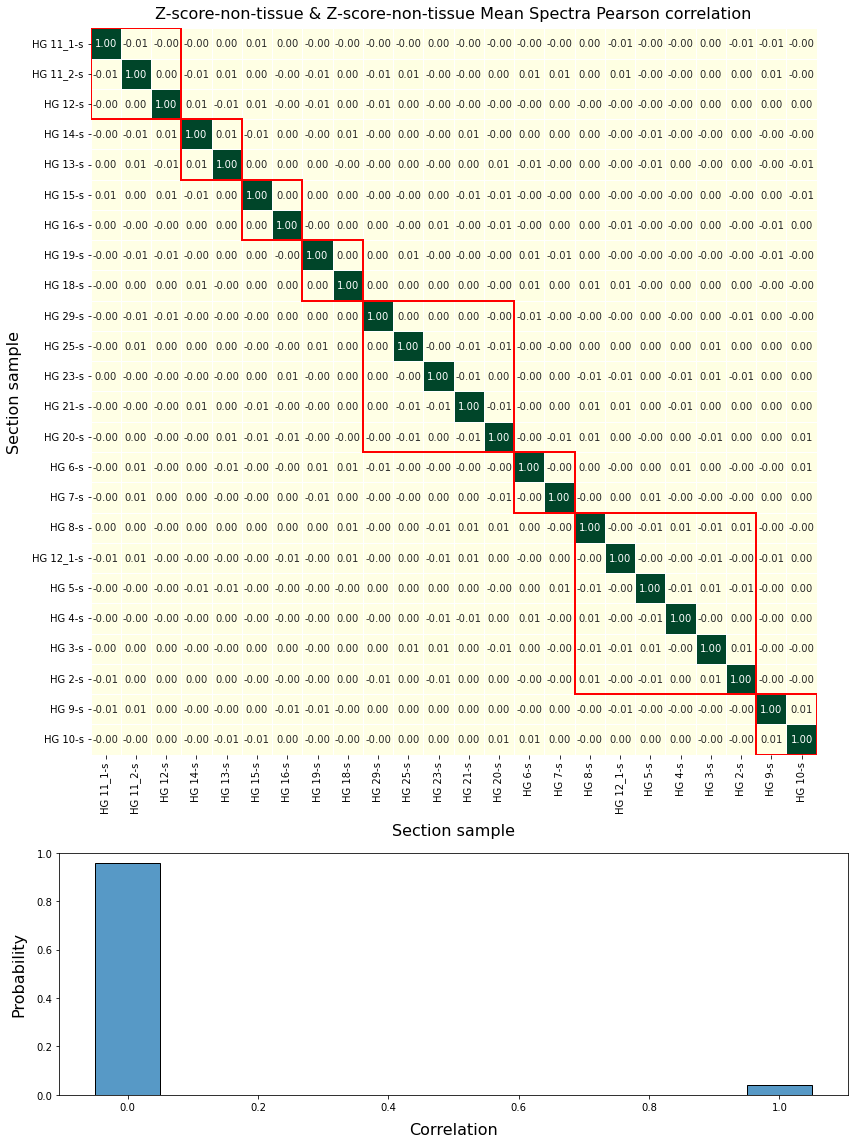

<Figure size 432x288 with 0 Axes>

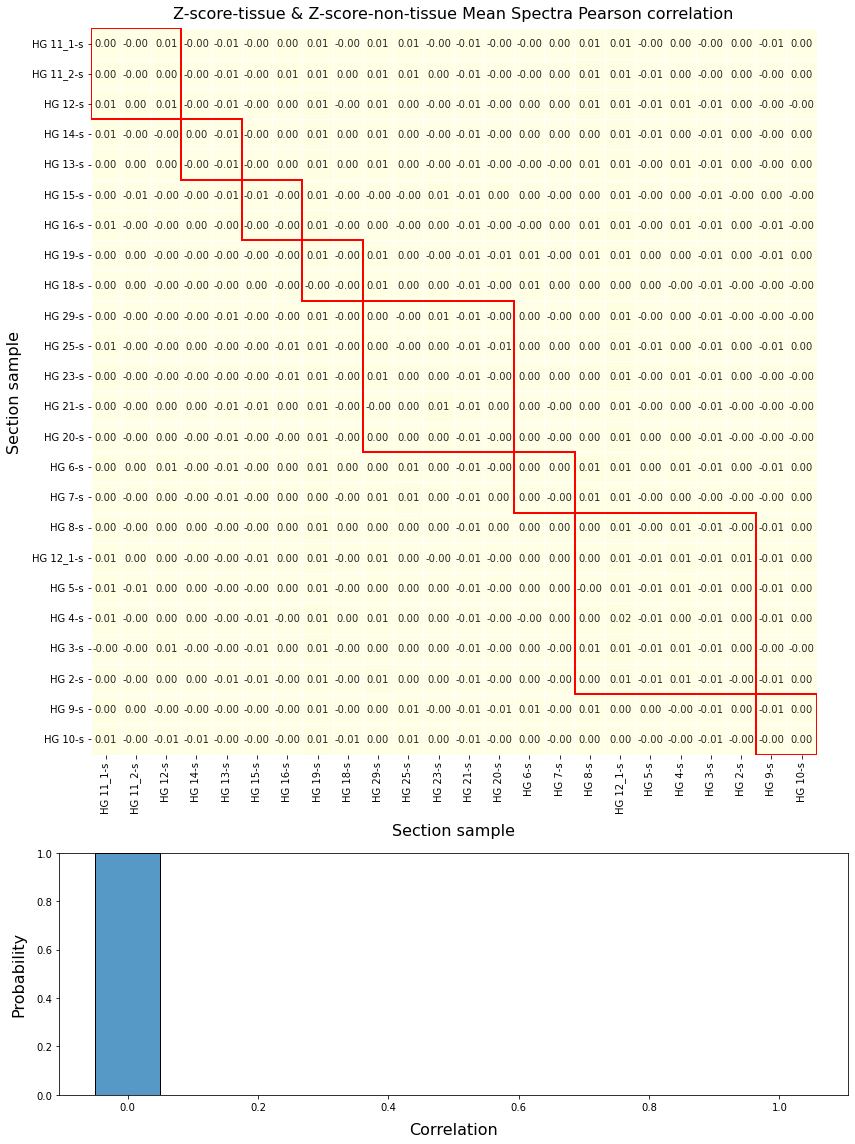

<Figure size 432x288 with 0 Axes>

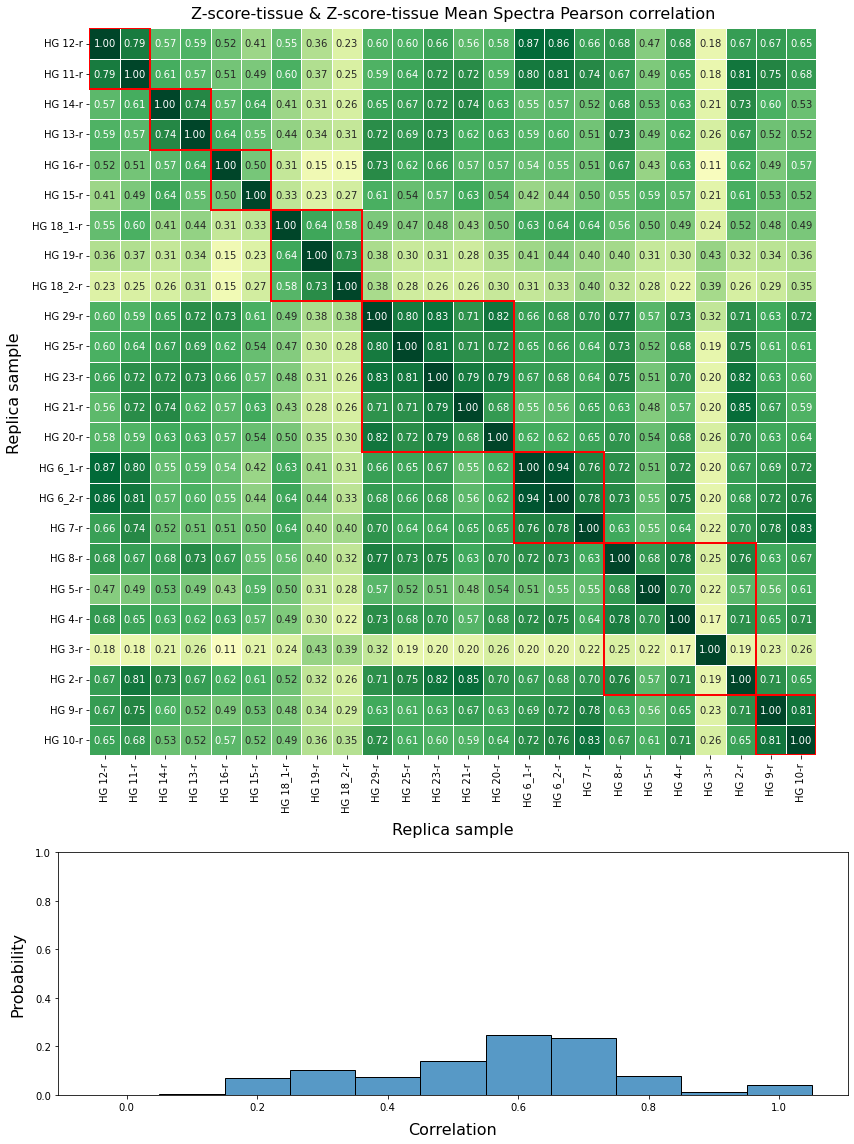

<Figure size 432x288 with 0 Axes>

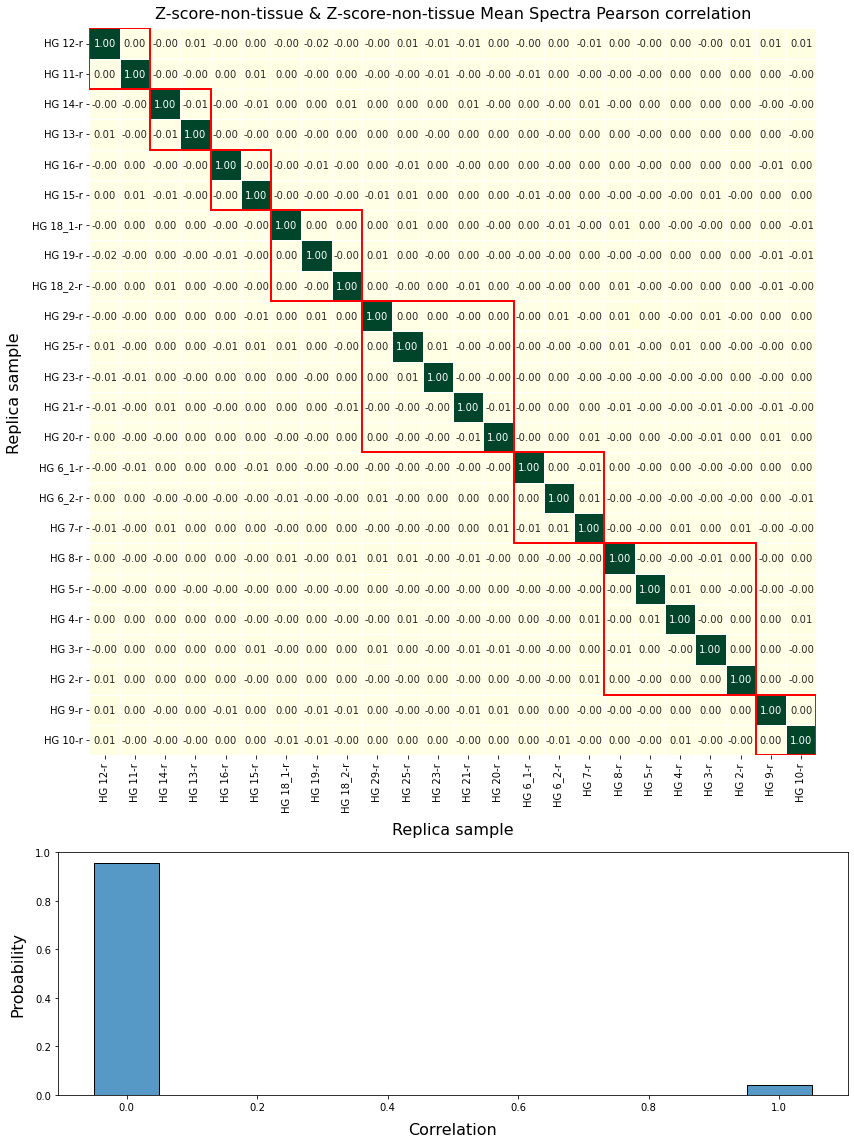

<Figure size 432x288 with 0 Axes>

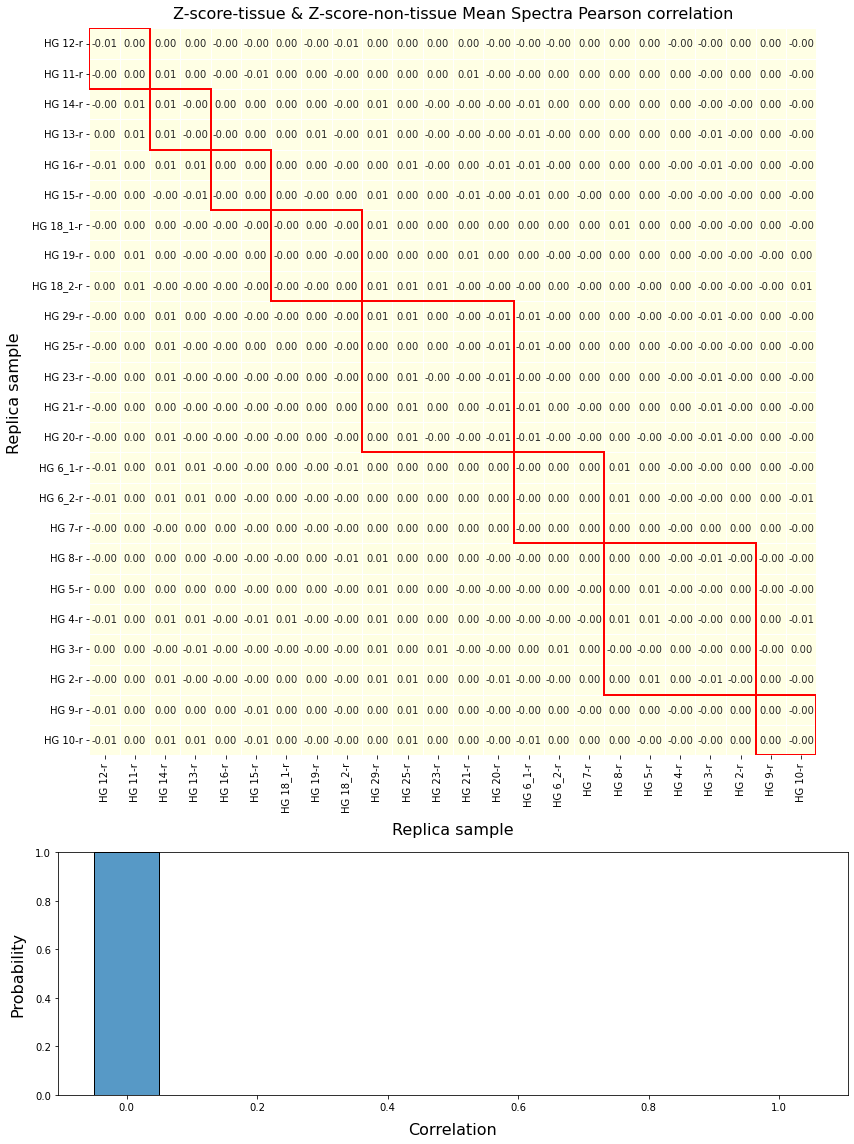

c:\Users\Leor\anaconda3\envs\tf_gpu_jup\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Figure size 432x288 with 0 Axes>

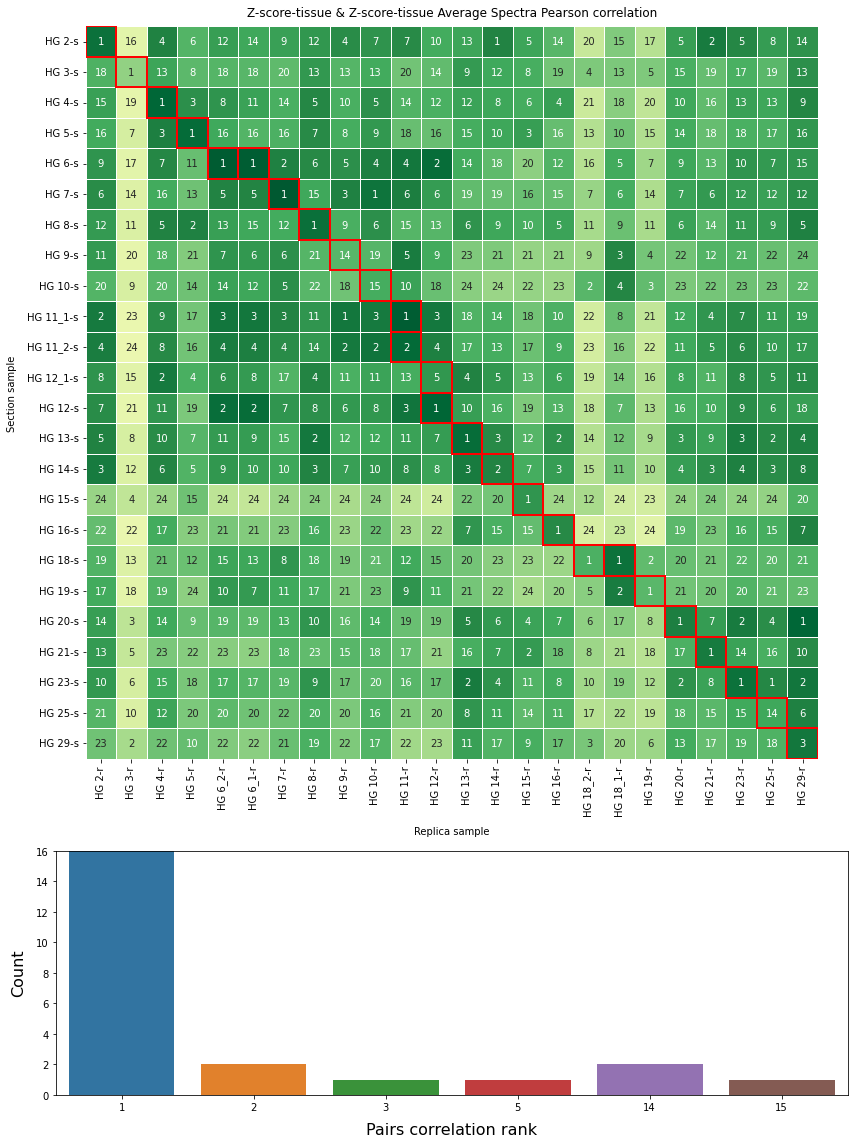

c:\Users\Leor\anaconda3\envs\tf_gpu_jup\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Figure size 432x288 with 0 Axes>

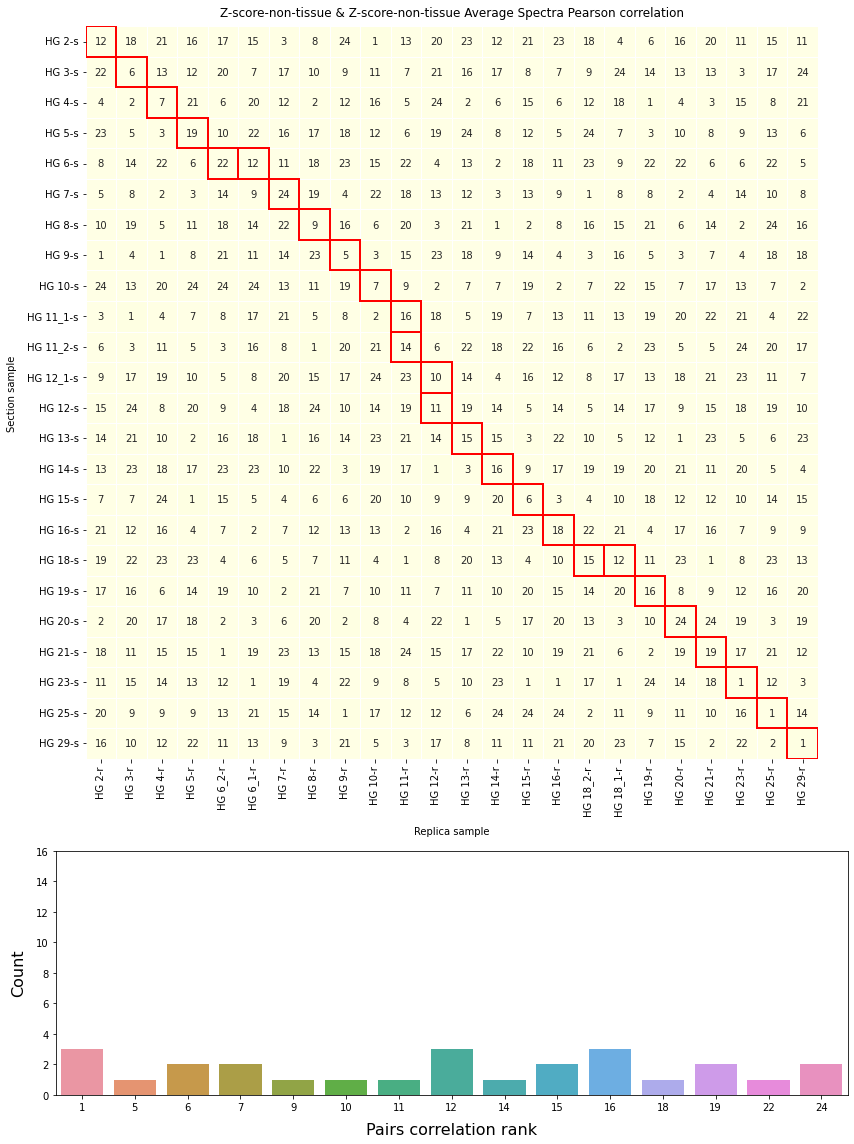

c:\Users\Leor\anaconda3\envs\tf_gpu_jup\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Figure size 432x288 with 0 Axes>

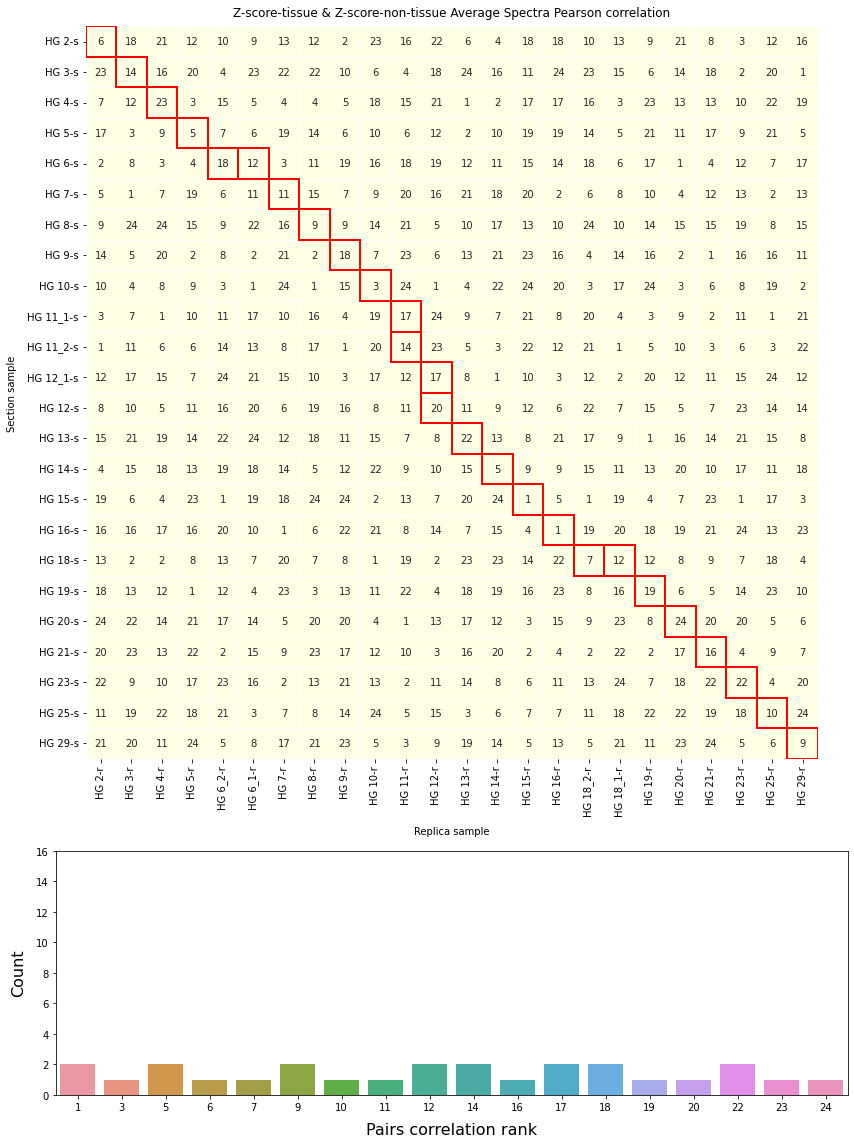

<Figure size 432x288 with 0 Axes>

In [10]:
# Plot correlations
for combination in combinations:
  # Get combination values
  sample_y_type, sample_x_type, spectra_y_type, spectra_x_type = combination

  # Create figure
  fig, axes = plt.subplots(
      2, 1, figsize=(12, 16), gridspec_kw={'height_ratios': [3, 1]},
      tight_layout=True
  )

  # Check sample types are the same
  if sample_y_type == sample_x_type:
    # Get correlation plot objects
    i_keys, j_keys, i_vals, j_vals = [plot_params_map[i] for i in combination]

    # Get correlation matrix
    corr_df = corr(
        i_keys.to_list(), j_keys.to_list(), i_vals, j_vals, corr_type=CORR_TYPE
    )

    # Plot Correlation matrix
    ax = sns.heatmap(
        corr_df, annot=True, cmap="YlGn", vmin=0, vmax=1, fmt=".2f",
        linewidth=.5, linecolor='w', square=True, cbar=False, ax=axes[0]
    )
    ax.set_title(
        (
            f"{spectra_y_type.capitalize()} & {spectra_x_type.capitalize()}"
            f" Mean Spectra Pearson correlation"
        ), pad=10, fontsize=16
    )
    ax.set_ylabel(
        f"{sample_y_type.capitalize()} sample", labelpad=10, fontsize=16
    )
    ax.set_xlabel(
        f"{sample_x_type.capitalize()} sample", labelpad=10, fontsize=16
    )

    # Mark cells of sample in same image
    for group_name, df_group in metadata_df[
        metadata_df.sample_type == sample_y_type].groupby('file_name'):
      start_i = i_keys[i_keys == df_group.iloc[0].sample_file_name].index[0]
      end_i = i_keys[i_keys == df_group.iloc[-1].sample_file_name].index[0]
      span = end_i - start_i + 1
      ax.add_patch(
          Rectangle(
              (start_i, start_i), span, span, fill=False, edgecolor="red", lw=2
          )
      )

    # Plot Correlation probability
    ax = sns.histplot(
        corr_df.values.reshape(-1), bins=np.arange(-0.05, 1.1, 0.1),
        stat="probability", ax=axes[1]
    )
    ax.set_ylabel("Probability", labelpad=10, fontsize=16)
    ax.set_xlabel("Correlation", labelpad=10, fontsize=16)
    ax.set_ylim((0, 1))

  else:
    # Get correlation plot objects
    i_keys, j_keys, i_vals, j_vals = [plot_params_map[i] for i in combination]
    i_keys = i_keys[i_keys.apply(lambda s: int(re.sub(r"HG |-s|-r|_.", "", s))
                                ).sort_values().index]
    j_keys = j_keys[j_keys.apply(lambda s: int(re.sub(r"HG |-s|-r|_.", "", s))
                                ).sort_values().index]

    # Get correlation matrix
    corr_df = corr(
        i_keys.to_list(), j_keys.to_list(), i_vals, j_vals, corr_type=CORR_TYPE
    )

    # Get ranks of correlation matrix
    ranks = corr_df.rank(axis=0, method="min", ascending=False).astype(int)

    # Plot correlation matrix
    ax = sns.heatmap(
        corr_df, annot=ranks, cmap="YlGn", vmin=0, vmax=1, fmt="d",
        linewidth=.5, linecolor='w', square=True, cbar=False, ax=axes[0]
    )
    ax.set_title(
        (
            f"{spectra_y_type.capitalize()} & {spectra_x_type.capitalize()}"
            f" Average Spectra Pearson correlation"
        ), pad=10
    )
    ax.set_ylabel(f"{sample_y_type.capitalize()} sample", labelpad=10)
    ax.set_xlabel(f"{sample_x_type.capitalize()} sample", labelpad=10)

    # Define list to save pair ranks
    pair_ranks = []

    # Mark cells of sample in same image
    for index_i, i in enumerate(corr_df.columns):
      for index_j, j in enumerate(corr_df.index):
        i_num = re.sub(r"HG |-s|-r|_.", "", i)
        j_num = re.sub(r"HG |-s|-r|_.", "", j)
        if i_num == j_num:
          ax.add_patch(
              Rectangle(
                  (index_i, index_j), 1, 1, fill=False, edgecolor="red", lw=2
              )
          )
          pair_ranks.append(ranks.loc[j, i])

    # Plot pair correlation rank count
    ax = sns.countplot(np.array(pair_ranks), ax=axes[1])
    ax.set_ylabel("Count", labelpad=10, fontsize=16)
    ax.set_xlabel("Pairs correlation rank", labelpad=10, fontsize=16)
    ax.set_ylim((0, 16))

  # Show plot
  plt.tight_layout()
  plt.savefig(
      (
          f"{PLOTS_PATH}/{sample_y_type}_{sample_x_type}_"
          f"{spectra_y_type}_{spectra_x_type}.png"
      ), transparent=True
  )
  plt.show()
  plt.clf()

### ***Plot multi replica correlation plots***

Next, let's plot multi replica correlation plots:

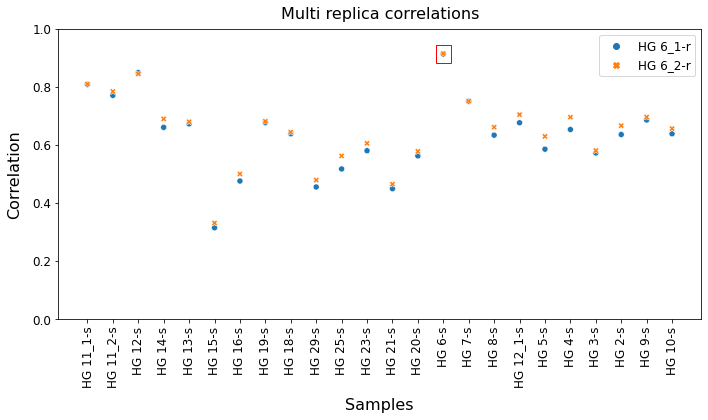

<Figure size 432x288 with 0 Axes>

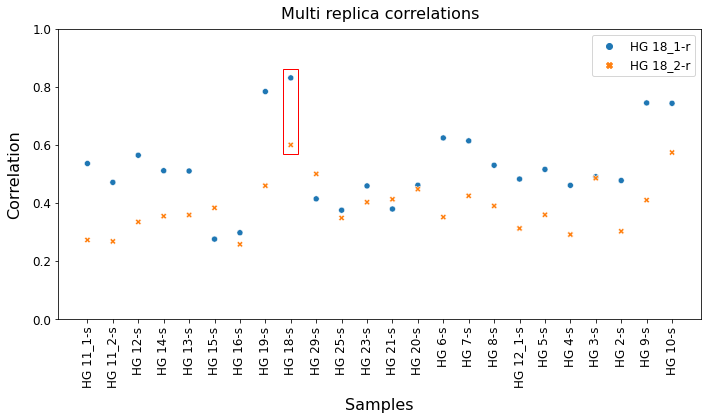

<Figure size 432x288 with 0 Axes>

In [11]:
# Set sample numbers with multiple replicas
multi_replica_samples = [6, 18]

# Plot correlations
for combination in [("section", "replica", "z-score-tissue", "z-score-tissue")]:
  # Get combination values
  sample_y_type, sample_x_type, spectra_y_type, spectra_x_type = combination

  # Get correlation plot objects
  i_keys, j_keys, i_vals, j_vals = [plot_params_map[i] for i in combination]

  # Get correlation matrix
  corr_df = corr(i_keys, j_keys, i_vals, j_vals, corr_type=CORR_TYPE)

  # Check sample types are not the same
  if sample_y_type != sample_x_type:
    # Loop over samples with multiple replicas
    for sample in multi_replica_samples:
      # Set section and replicas
      section = f"HG {sample}-s"
      replica_1 = f"HG {sample}_1-r"
      replica_2 = f"HG {sample}_2-r"
      
      # Create figure
      fig, axes = plt.subplots(1, figsize=(10, 6))  

      # Create scatter plot
      ax = sns.scatterplot(data=corr_df.loc[:, [replica_1, replica_2]], ax=axes)

      # Set plot params
      ax.set_ylim(0, 1)
      ax.tick_params('x', labelrotation=90)
      ax.set_title(f"Multi replica correlations", pad=10, fontsize=16)
      ax.set_ylabel(f"Correlation", labelpad=10, fontsize=16)
      ax.set_xlabel(f"Samples", labelpad=10, fontsize=16)
      ax.legend(title="")

      # Add square above the corresponding replicas
      replica_1_corr = corr_df.loc[section, replica_1]
      replica_2_corr = corr_df.loc[section, replica_2]
      x = np.where(corr_df.index == section)[0][0] - 0.3
      y = np.min([replica_1_corr, replica_2_corr]) - 0.03
      span = np.max([replica_1_corr, replica_2_corr]) - y + 0.03
      ax.add_patch(
          Rectangle((x, y), 0.6, span, fill=False, edgecolor="red", lw=1)
      )

      # Show plot
      plt.tight_layout()
      plt.savefig(
          (
              f"{PLOTS_PATH}/{sample_y_type}_{sample_x_type}_"
              f"{spectra_y_type}_{spectra_x_type}_{sample}_multi_replica.png"
          ), transparent=True
      )
      plt.show()
      plt.clf()

### ***Save data for plot creation***

Next, let's save the data used to create the plots:

In [12]:
# Create data frame for each means of sample
sample_tissue_mean_df = pd.DataFrame(
    np.array(list(sample_tissue_mean.values())), columns=mzs,
    index=list(sample_tissue_mean.keys())
)
sample_non_tissue_mean_df = pd.DataFrame(
    np.array(list(sample_non_tissue_mean.values())), columns=mzs,
    index=list(sample_non_tissue_mean.keys())
)
zscore_sample_tissue_mean_df = pd.DataFrame(
    np.array(list(z_score_sample_tissue_mean.values())), columns=mzs,
    index=list(z_score_sample_tissue_mean.keys())
)
zscore_sample_non_tissue_mean_df = pd.DataFrame(
    np.array(list(z_score_sample_non_tissue_mean.values())), columns=mzs,
    index=list(z_score_sample_non_tissue_mean.keys())
)

# Save to csv
sample_tissue_mean_df.to_csv(f"{PLOTS_PATH}/sample_tissue_mean.csv")
sample_non_tissue_mean_df.to_csv(f"{PLOTS_PATH}/sample_non_tissue_mean.csv")
zscore_sample_tissue_mean_df.to_csv(
    f"{PLOTS_PATH}/zscore_sample_tissue_mean.csv"
)
zscore_sample_non_tissue_mean_df.to_csv(
    f"{PLOTS_PATH}/zscore_sample_non_tissue_mean.csv"
)